## **Case study 2: Techno-economic comparison of hydrogen production pathways**
<p style='text-align: justify;'>Hydrogen (H₂) production is a cornerstone of a low-carbon energy system, with technologies such as <b>steam methane reforming (SMR)</b>, <b>methane pyrolysis (MP)</b>, and <b>renewable-powered water electrolysis (WE)</b> offering different trade-offs in efficiency, cost, and environmental impact. Their varied energy demands, carbon intensities, and capital requirements make rigorous techno-economic assessment (TEA) essential for identifying scalable, cost-effective pathways.</p>

<p style='text-align: justify;'>In this case study, we apply <b>OpenPyTEA</b> to consistently evaluate the technical and economic performance of SMR, MP, and WE. The analysis covers capital cost (CAPEX), operating cost (OPEX), levelized cost of H₂ (LCOH), sensitivity analysis and Monte Carlo–based uncertainty analysis. This demonstrates how <b>OpenPyTEA</b> streamlines scenario setup, parameter management, and results analysis, enabling transparent and reproducible comparison across H₂ production technologies.</p>

Let's start first by importing <b>OpenPyTEA</b>:

In [1]:
from openpytea.equipment import *
from openpytea.plant import *
from openpytea.analysis import *

To ensure a consistent comparison across all processes, we will now define the economic assumptions applied to each. Here, we assume that all processes are used to produce 50 tonnes per day of H₂.

In [2]:
country, region = 'United States', 'Gulf Coast'                                                 # In this case study, we take USA-Gulf Coast as an example
interest_rate, project_lifetime, plant_utilization = 0.09, 20, 0.95                             # Base project assumptions
h2_prod = 50_000                                                                                # Daily H₂ production in kg (50 tonnes/day)

# labor costs and uncertainties
operator_rate, operator_std, operator_max, operator_min = 38.11, 10, 50, 25                     # Operator hourly rate for USA-Gulf Coast, in US$/h
# utilities and raw materials prices and uncertainties
elecs_price, elecs_std, elecs_max, elecs_min =  0.05, 0.05/2, 3, 0.01                           # Price of electricity, in US$/kWh
nat_gas_price, nat_gas_std, nat_gas_max, nat_gas_min =  0.5, 0.2/2, 5, 0                        # Price of natural gas, in US$/kg
cool_water_price, cool_water_std, cool_water_max, cool_water_min = 2.4592e-4, 1e-4, 4e-4, 1e-5  # Price of cooling water, in US$/MJ
co2_tax, co2_std, co2_max, co2_min =  0.072, 0.02, 0.15, 0                                      # Price of CO2 Tax, in US$/kg CO2


The following sections present the process design and economic assessment for each H₂ production pathway. Process parameters for SMR and MP shown in the respective process flow diagrams are derived from Aspen Plus simulations. The corresponding simulation files are provided in the folder `aspen_plus_sims`. For WE, we based the capital costs and operating energy consumption from U.S. Department of Energy TEA report for H₂ production cost with alkaline electrolysis [1].

---------------------
### Steam Methane Reforming (SMR)

<p style='text-align: justify;'>SMR is the most established and widely used H₂ production technology, supplying over half of global H₂ demand. In SMR, methane reacts with high-temperature steam over a nickel catalyst to form synthesis gas, which is then processed in a water–gas shift reactor to increase H₂ yield. While SMR is efficient and relatively low-cost, it is also carbon dioxide (CO₂)-intensive due to CO₂ generated in both the reforming reaction and furnace combustion. CO₂ capture can reduce emissions but adds capital and operating costs, underscoring the need for TEA to evaluate its long-term competitiveness.</p>

<p style='text-align: justify;'>This SMR case study is adapted from the flow sheet in Boyano et al. [2], while the kinetic models follow Xu & Froment [3] and Choi & Stenger [4] for SMR and water–gas shift (WGS) reactions, respectively. The SMR reaction takes place in a catalytic reactor that operates isothermally at 700 °C, followed by the WGS reaction in high- and low-temperature WGS reactors. Hydrogen gas is separated via pressure-swing adsorption, while the remaining gases are combusted to supply heat for the SMR process (supplemented by additional methane feed). Steam for the reaction is generated by heating water using heat recovered from the WGS reactors and methane combustion. </p>

<p style='text-align: justify;'>The following figure presents the MP process flow diagram, and the accompanying table summarizes the equipment sizing:</p>

![case_study_2-figure_1](img/CS_2-Fig_1.png)
**<p style='text-align: justify; font-size: 90%;'>Figure 1.** Process flow diagram of the SMR system. The diagram illustrates compression and mixing of the methane feed, preheating in HEATER-1, and catalytic reforming in the SMR reactor. The reactor effluent is cooled and sent through high-temperature (WGS-HT) and low-temperature (WGS-LT) water–gas shift reactors to increase H₂ yield. Heat exchangers (HX-1, HX-2, HX-3) recover energy for steam generation and feed preheating. Hydrogen is purified via pressure-swing adsorption (PSA), while the off-gas is routed to a furnace for combustion along with supplemental fuel. Combustion heat is used to support endothermic SMR reactions and additional heating duties within the process.</p>

<center>
<p style="font-size: 90%;"><b>Table 1.</b> Process equipment sizing for SMR</p>
<span style="font-size: 14px">

| **Equipment** | **Sizing Parameter** | **Unit** | **Equipment** | **Sizing Parameter** | **Unit** |
|---------------|-----------------------|----------|---------------|-----------------------|----------|
| Comp-1        | 945                   | kW       | SMR-REAC      | 91.56                 | kg       |
| Comp-2        | 491                   | kW       | WGS-HT-REAC   | 376.54                | kg       |
| HX-1          | 31.87                 | m²       | WGS-LT-REAC   | 3822.92               | kg       |
| HX-2          | 22.74                 | m²       | Pump          | 5.16                  | L/s      |
| HX-3          | 107.19                | m²       | PSA           | 1023.49               | kmol/h   |
| Furnace       | 33.26                 | MW       | Cooler        | 191.47                | m²       |

</span></center>

Now, we create the SMR process equipment objects:

In [3]:
# First, we create the compressor and electric-motor (for driving the compressors) objects.
# We choose here the centrifugal type for both compressors.
comp_1_pwr = 945 # kW
comp_2_pwr = 491 # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")

# When the electric motor drives the compressors there are some losses involved. Here we assumed 90% efficiency.
mtr_eff = 0.9
mtr_1_pwr, mtr_2_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Next, we create heat exchanger objects, modeled shell & tube.
hx_1 = Equipment('HX-1', 31.87, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
hx_2 = Equipment('HX-2', 22.74, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
hx_3 = Equipment('HX-3', 107.19, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
cooler = Equipment('COOLER', 191.47, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')

# Now we create the reactor objects for the SMR and WGS reactors.
smr_reactor = Equipment('SMR-REACTOR', 160, "Fluids", "Reactors", "Tubular fixed bed", "304 stainless steel")
wgs_ht_reactor = Equipment('WGS-HT-REACTOR', 376.54, "Fluids", "Reactors", "Tubular fixed bed", "304 stainless steel")
wgs_lt_reactor = Equipment('WGS-LT-REACTOR', 3822.92, "Fluids", "Reactors", "Tubular fixed bed", "304 stainless steel")

# Now for the remaining equipment.
furnace = Equipment('FURNACE', 33.26, "Fluids", "Boilers, heaters, & furnaces", "Furnace, cylindrical", "304 stainless steel")
pump = Equipment('PUMP', 5.16, "Fluids", "Pumps", "Single-stage centrifugal", "Carbon steel")
psa = Equipment('PSA', 1023.49, "Fluids", "Gas separation", "Pressure-swing adsorber", "Carbon steel")

# We can now create a list of the equipment for the SMR process.
smr_equipment = [
    comp_1, mtr_1,
    comp_2, mtr_2,
    hx_1, hx_2, hx_3,
    cooler,
    smr_reactor, 
    wgs_ht_reactor, wgs_lt_reactor,
    furnace, pump, psa
]

Next, we create the SMR plant object:

In [4]:
# Configuration for the SMR plant
config = {'plant_name': 'Steam Reforming',
          'process_type': 'Fluids',     # Since there are only fluids, we choose 'Fluids'
          'country': country, 'region': region,
          'equipment': smr_equipment,   # This the list of equipment for the SMR process
          'interest_rate': interest_rate, 'project_lifetime': project_lifetime, 'plant_utilization': plant_utilization, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': operator_rate, 'std': operator_std, 'max': operator_max, 'min': operator_min
              },
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'hydrogen': {
                  'production': h2_prod, # Daily production in kg/day,
              }
            },
          'variable_opex_inputs': {     # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (mtr_1_pwr + mtr_2_pwr)*24, 'price': elecs_price, 'std': elecs_std, 'max': elecs_max, 'min': elecs_min
              },
              'methane_feed':{          # We assume the methane feed is natural gas. They are use as the main feedstock for the process as well as heating fuel
                  'consumption': (5139+4025)*24, 'price': nat_gas_price, 'std': nat_gas_std, 'max': nat_gas_max, 'min': nat_gas_min
              },
              'cooling_water': {        # Cooling duties in Cooler (the value comes from the Aspen Plus simulation)
                  'consumption': (20222.67)*24, 'price': cool_water_price, 'std': cool_water_std, 'max': cool_water_max, 'min': cool_water_min
              },
              'CO2_tax': {
                  'consumption': 25124.64*24, 'price': co2_tax, 'std': co2_std, 'max': co2_max, 'min': co2_min
              },
            },
}
smr_plant = Plant(config)               # Create the process plant object. Here we name it smr_plant.

The following lines calculate for the CAPEX, OPEX and LCOH of the SMR plant:

In [5]:
smr_plant.calculate_fixed_capital(print_results=True)   # Calculate the FCI and print the details
smr_plant.calculate_variable_opex(print_results=True)   # Calculate the Variable OPEX and print the details
smr_plant.calculate_levelized_cost(print_results=True)  # Calculate the LCOH and print the details

Capital cost estimation
ISBL: $29,145,338.16
OSBL: $8,743,601.45
Design and engineering: $11,366,681.88
Contingency: $3,788,893.96
Fixed capital investment: $53,044,515.46
Variable production costs estimation
  - Electricity: $663,910.67 per year
  - Methane feed: $38,131,404.00 per year
  - Cooling water: $41,386.63 per year
  - Co2 tax: $15,054,282.29 per year
Total Variable OPEX: $53,890,983.59 per year
Levelized cost: $4.451/unit


We now run the Monte Carlo simulation. The results are not presented at this stage; they will be shown later using `plot_multiple_monte_carlo` for comparison across the technologies.

In [6]:
monte_carlo(smr_plant, num_samples=1_000_000, batch_size=1000)

Monte Carlo: 100%|██████████| 1000/1000 [01:01<00:00, 16.22it/s]


({'LCOP': array([4.30029243, 4.30029243, 4.30029243, ..., 4.32140056, 4.32140056,
         4.32140056], shape=(1000000,)),
  'ROI': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'NPV': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'PBT': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,))},
 {'Fixed capital factor': array([0.86561835, 0.75445377, 1.66042637, ..., 1.2741437 , 0.80291668,
         1.24988963], shape=(1000000,)),
  'Fixed opex factor': array([0.8122802 , 1.11870138, 0.94163844, ..., 0.69810135, 0.43557542,
         1.19343937], shape=(1000000,)),
  'Operator hourly rate': array([31.06324505, 26.99759869, 31.71037763, ..., 26.25060983,
         37.00582652, 28.2828861 ], shape=(1000000,)),
  'Project lifetime': array([24.94348378, 21.02853046, 12.1773077 , ..., 21.07832573,
         22.75852872, 20.579853  ], shape=(1000000,)),
  'Interest rate': array([0.11414205, 0.03022321, 0.12521595, ..., 0.12059993, 0.08910849,
         0.11231915], shape=(

---------------

### Methane Pyrolysis (MP)
<p style='text-align: justify;'>MP produces H₂ without direct CO₂ emissions by thermally splitting methane into H₂ and solid carbon. Depending on the heat source—such as plasma, molten metal, or non-catalytic reactors—the process exhibits different efficiencies and scale-up challenges. When powered by renewable or waste heat, MP offers a low-carbon H₂ pathway, though its economics depend heavily on reactor design, heat supply, and the management or valorization of the solid carbon by-product.</p>

<p style='text-align: justify;'>This case study follows the non-catalytic MP process of Keipi et al. [5,6], using a regenerative heat-exchanger reactor (RHER). Methane is cracked at 1300 K, producing H₂ while depositing solid carbon. In addition to external heating, hot product gases heat a circulating bed of ceramic beads, which in turn preheat the incoming methane. Most carbon forms on the bead surfaces and is removed through the circulation loop. For simplicity, detailed modeling of the bed-material loop and downstream carbon-handling units is omitted.</p>

<p style='text-align: justify;'>The following figure presents the MP process flow diagram, and the accompanying table summarizes the equipment sizing:</p>

![case_study_2-figure_2](img/CS_2-Fig_2.png)
**<p style='text-align: justify; font-size: 90%;'>Figure 2.** Process flow diagram of a MP system producing H₂ and solid carbon. Fresh methane feed is compressed (COMP-1) and preheated in heat exchanger (HX-1) before entering the moving bed reactor, where endothermic pyrolysis occurs and using a heated bed material circulated to separate the gas-solid products. Combustion of a CH₄–air stream (COMP-3) supplies the thermal energy, and the resulting flue gas exits the system. Carbon particulates are separated in a cyclone and routed to a dedicated carbon-bed material separation unit for solid carbon recovery. The gas products from the reactor is cooled (COOLER-1, COOLER-2), compressed (COMP-2), and purified in a Pressure Swing Adsorption (PSA) unit to produce a H₂ stream, while unreacted methane is recycled to the reactor.</p>


<center>
<p style="font-size: 90%;"><b>Table 2.</b> Process equipment sizing for MP.</p>
<span style="font-size: 14px">

| **Equipment** | **Sizing Parameter** | **Unit** | **Equipment** | **Sizing Parameter** | **Unit** |
|---------------|-----------------------|----------|---------------|-----------------------|----------|
| Comp-1        | 205                   | kW       | HX-1          | 28.37                 | m²       |
| Comp-2        | 2993                  | kW       | COOLER-1      | 41.85                 | m²       |
| Comp-3        | 363                   | kW       | COOLER-2      | 26.21                 | m²       |
| Reactor       | 147.26                | m³       | Cyclone       | 36.70                 | m³/s     |
| Furnace       | 22608                 | kW       | PSA           | 1017.98               | kmol/h   |

</span></center>

As in the previous case study, we first create the process-equipment objects:

In [7]:
# First, we create the compressor and electric-motor (for driving the compressors) objects.
# We choose here the centrifugal type for both compressors, as in the SMR case.
comp_1_pwr = 205 # kW
comp_2_pwr = 2993 # kW
comp_3_pwr = 363 # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")
comp_3 = Equipment('COMP-3', comp_3_pwr, "Fluids", "Compressors, fans, & blowers", "Compressor, centrifugal", "Carbon steel")

# When the electric motor drives the compressors there are some losses involved. Here we assumed 90% efficiency.
mtr_eff = 0.9
mtr_1_pwr, mtr_2_pwr, mtr_3_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff, comp_3_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_3 = Equipment('MTR-3', mtr_3_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Next, we create the shell & tube heat exchanger objects.
hx_1 = Equipment('HX-1', 28.37, "Fluids", "Heat Exchangers", "U-tube shell & tube", '316 stainless steel')
cooler_1 = Equipment('COOLER-1', 41.85, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')
cooler_2 = Equipment('COOLER-2', 26.21, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')

# Now we create the reactor, furnace, cyclone and PSA objects.
reactor = Equipment('REACTOR', 147.26, "Mixed", "Reactors", "Indirect fluidized-bed", "316 stainless steel")
furnace = Equipment('FURNACE', 22608, "Fluids", "Boilers, heaters, & furnaces", "Pyrolysis furnace", "316 stainless steel")
cyclone = Equipment('CYCLONE', 36.70, "Mixed", "Dust collectors", "Gas multi-cyclone", "316 stainless steel")
psa = Equipment('PSA', 1017.98, "Fluids", "Gas separation", "Pressure-swing adsorber", "Carbon steel")

# We can now create a list of the equipment for the MP process.
mp_equipment = [
    comp_1, mtr_1,
    comp_2, mtr_2,
    comp_3, mtr_3,
    hx_1, cooler_1, cooler_2,
    reactor, furnace,
    cyclone, psa
]

Next, we create the MP plant object:

In [8]:
# Configuration for the MP plant
config = {'plant_name': 'Methane Pyrolysis',
          'process_type': 'Mixed',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': country, 'region': region,
          'equipment': mp_equipment, # This the list of equipment for the MP process
          'interest_rate': interest_rate, 'project_lifetime': project_lifetime, 'plant_utilization': plant_utilization, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': operator_rate, 'std': operator_std, 'max': operator_max, 'min': operator_min
              },
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'hydrogen': {
                  'production': h2_prod, # Daily production in kg/day,
              },
              'carbon': {
                  'production': 6100*0.5*24,  'price': 1, 'std': 0.5/2, 'max': 3, 'min': 0 # Daily production in kg/day,
              }
            },
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (mtr_1_pwr + mtr_2_pwr + mtr_3_pwr)*24, 'price': elecs_price, 'std': elecs_std, 'max': elecs_max, 'min': elecs_min
              },
              'methane_feed':{ # We assume the methane feed is natural gas. They are use as the main feedstock for the process as well as heating fuel
                  'consumption': (8184+3775)*24, 'price': nat_gas_price, 'std': nat_gas_std, 'max': nat_gas_max, 'min': nat_gas_min
              },
              'cooling_water': { # Cooling duties in Cooler-1, Cooler-2 and Comp-2 intercoolers (the value comes from the Aspen Plus simulation)
                  'consumption': (12816.41+1313.09+9443.57)*24, 'price': cool_water_price, 'std': cool_water_std, 'max': cool_water_max, 'min': cool_water_min
              },
              'CO2_tax': {
                  'consumption': 10357*24, 'price': co2_tax, 'std': co2_std, 'max': co2_max, 'min': co2_min
              },
              'carbon_disposal_fee': { # the remaining 50% must be disposed of at a cost
                  'consumption': 6100*0.5*24, 'price': 0.5, 'std': 0.5/2, 'max': 1, 'min': 0
              },
            }
}
mp_plant = Plant(config)  # Create the process plant object. Here we name it mp_plant.

CAPEX, OPEX and LCOH calculation:

In [9]:
mp_plant.calculate_cash_flow(print_results=True)   # Calculate the FCI and print the details

,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$22,829,044.57",$0.00,"$24,714,286.95","$-24,714,286.95",$0.00,"$-24,714,286.95",$0.00,"$-47,543,331.52"
1,2,"$45,658,089.14",$0.00,"$24,714,286.95","$-24,714,286.95",$0.00,"$-24,714,286.95",$0.00,"$-70,372,376.09"
2,3,"$19,024,203.81","$10,152,840.00","$52,855,410.97","$-42,702,570.97","$5,073,121.02","$-47,775,691.99",$0.00,"$-61,726,774.78"
3,4,$0.00,"$20,305,680.00","$80,996,535.00","$-60,690,855.00","$5,073,121.02","$-65,763,976.02",$0.00,"$-60,690,855.00"
4,5,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"
5,6,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"
6,7,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"
7,8,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"
8,9,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"
9,10,$0.00,"$25,382,100.00","$95,067,097.01","$-69,684,997.01","$5,073,121.02","$-74,758,118.03",$0.00,"$-69,684,997.01"


In [10]:
mp_plant.calculate_fixed_capital(print_results=True)   # Calculate the FCI and print the details
mp_plant.calculate_variable_opex(print_results=True)   # Calculate the Variable OPEX and print the details
mp_plant.calculate_revenue(print_results=True)   # Calculate the Revenues and print the details
mp_plant.calculate_levelized_cost(print_results=True)  # Calculate the LCOH and print the details

Capital cost estimation
ISBL: $40,262,865.21
OSBL: $16,105,146.08
Design and engineering: $14,092,002.82
Contingency: $5,636,801.13
Fixed capital investment: $76,096,815.24
Variable production costs estimation
  - Electricity: $1,646,369.00 per year
  - Methane feed: $49,761,399.00 per year
  - Cooling water: $48,243.38 per year
  - Co2 tax: $6,205,748.69 per year
  - Carbon disposal fee: $12,691,050.00 per year
Total Variable OPEX: $70,352,810.07 per year
Revenue estimation
  - Hydrogen: $0.00 per year
  - Carbon: $25,382,100.00 per year
Total Revenue: $25,382,100.00 per year
Levelized cost: $5.132/unit


Monte Carlo simulation:

In [11]:
monte_carlo(mp_plant, num_samples=1_000_000, batch_size=1000)

Monte Carlo: 100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


({'LCOP': array([4.91713731, 4.91713731, 4.91713731, ..., 4.98394979, 4.98394979,
         4.98394979], shape=(1000000,)),
  'ROI': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'NPV': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'PBT': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,))},
 {'Fixed capital factor': array([0.92539437, 0.75405324, 0.73953745, ..., 1.4529279 , 0.65313691,
         1.49262768], shape=(1000000,)),
  'Fixed opex factor': array([0.8658175 , 0.94459861, 0.998018  , ..., 0.93723614, 1.08507702,
         1.08620349], shape=(1000000,)),
  'Operator hourly rate': array([45.53263006, 40.74914785, 35.4004923 , ..., 27.89207641,
         37.29056759, 36.05991537], shape=(1000000,)),
  'Project lifetime': array([17.26681135, 26.52972582, 11.24370551, ..., 21.14743353,
         17.1022629 , 23.24148224], shape=(1000000,)),
  'Interest rate': array([0.08561627, 0.09351896, 0.07480597, ..., 0.08912535, 0.11446147,
         0.03040257], shape=(

-------------------------------
### Water Electrolysis (WE)
<p style='text-align: justify'>WE produces H₂ by splitting water into H₂ and oxygen (O₂) using electricity. Alkaline, PEM, and solid oxide electrolyzers vary in efficiency, operational flexibility, and capital cost, but all can deliver zero on-site emissions when powered by renewable electricity. Although widely viewed as a cornerstone of green H₂ production, the economics of electrolysis remain highly sensitive to electricity price, capacity factor, and stack replacement costs. As renewable power becomes cheaper and more abundant, rigorous TEA is essential for understanding the future role of electrolysis in low-carbon energy systems.</p>

<p style='text-align: justify;'>This case study follows the high-pressure (HP) alkaline electrolysis system described in the DOE TEA by Acevedo et al. (4), operating at approximately 30 bar to produce H₂ without downstream compression. Purified water and 30 wt% KOH circulate through zero-gap cells employing nickel-based electrodes and a Zirfon diaphragm, generating H₂ that exits the pressurized cathode manifold. The H₂ purification system consists of a deoxidizer and a dual-bed TSA unit to remove residual oxygen and moisture before delivering 99.99% pure H₂. Electrical conditioning equipment supplies constant current, while gradual voltage degradation is omitted for simplicity.</p>

<p style='text-align: justify;'>The following is the process flow diagram of the pressurized alkaline WE systems:</p>

![case_study_2-figure_3](img/CS_2-Fig_3.png)
**<p style='text-align: justify; font-size: 90%;'>Figure 3.** Process flow diagram of a HP alkaline WE system. Makeup water is filtered and deionized before entering the KOH scrubber, where it mixes with recycled water. The pressurized electrolyzer stack receives this KOH solution via the feed pump and generates H₂ and oxygen in electrolyzer cells. Cathode and anode effluent streams are routed to dedicated separators to remove entrained liquid electrolyte, which is recycled. The pressurized H₂ stream enters the purification subsystem, where a deoxygenation reactor removes residual oxygen before a temperature swing adsorption unit dries the gas to product purity. Oxygen from the anode is vented, while purified H₂ exits as the product. Electrical balance-of-plant (BOP) components, including the AC transformer and rectifier, provide the DC power required for stack operation.</p>

<p style='text-align: justify;'>The DOE TEA reports the estimated uninstalled (purchased) capital costs for a high-pressure alkaline WE plant at a 50 TPD capacity projected for 2030. The beginning-of-life power requirement of the system is <b>98 MW (AC input)</b>. These values are adopted here for our comparison study. Table 3 below summarizes the uninstalled capital costs for the stack and the mechanical and electrical balance-of-plant (BOP) components, presented in 2020 cost-year terms:</p>

<center>
<p style="font-size: 90%;"><b>Table 3.</b> Uninstalled capital costs for the 50-TPD HP alkaline system.</p>
<span style="font-size: 14px">

| **Uninstalled Capital Costs**| **Price**         |
|------------------------------|-------------------|
| Stack Capital Cost           | $17 194 000       |
| Mechanical BOP               | $11 019 000       |
| Electrical BOP               | $16 974 000       |
| **Total**                    | **$45 186 000**   |

</span></center>

<p style='text-align: justify;'>Based on these data, let us create the equipment objects for the HP alkaline system:</p>

In [12]:
electrolyzer_stack = Equipment('Stack', 0, "Fluids", "Electrolysis", "Stack", "Carbon steel", purchased_cost=17_194_000, cost_year=2020)
mechanical_bop = Equipment('Mechanical BOP', 0, "Fluids", "Electrolysis", "Mechanical", "Carbon steel", purchased_cost=11_019_000, cost_year=2020)
electrical_bop = Equipment('Electrical BOP', 0, "Electrical", "Electrolysis", "Electrical", "Carbon steel", purchased_cost=16_974_000, cost_year=2020)

# Here, we create the list of the equipment for the water electrolysis process.
we_equipment = [
    electrolyzer_stack,
    mechanical_bop,
    electrical_bop
]

We now create the Plant object, considering only electricity and water consumption as variable OPEX.

In [13]:
config = {'plant_name': 'Water Electrolysis',
          'process_type': 'Fluids',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': country, 'region': region,
          'equipment': we_equipment, # This the list of equipment for the MP process
          'interest_rate': interest_rate, 'project_lifetime': project_lifetime, 'plant_utilization': plant_utilization, # Base economic assumptions
          'operator_hourly_rate': {
              'rate': operator_rate, 'std': operator_std, 'max': operator_max, 'min': operator_min
              },
          'plant_products': {  # Here we define the products and/or inputs of the plant
              'hydrogen': {
                  'production': h2_prod, # Daily production in kg/day,
              },
            },
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (98*1000)*24, 'price': elecs_price, 'std': elecs_std, 'max': elecs_max, 'min': elecs_min
              },
              'water': {
                    'consumption': 3.78*50_000, 'price': 0.00237, 'std': 0.001, 'max': 0.005, 'min': 0
              }
            },
}
we_plant = Plant(config)  # Create the process plant object. Here we name it mp_plant.

<p style="text-align: justify;"> Before proceeding, we need to redefine the number of operators hired. If left unspecified, the default settings estimate operator needs based on the number of fluid and solid processes, which is inaccurate here because we define systems (stack, mechanical, and electrical BOPs) rather than individual process units. We can utilize the <code>calculate_operators_hired</code> function from <code>openpytea.plant</code> object to estimate the number of operators based on process steps. From the process flow diagram, we count 11 fluid processes and 0 solid processes (excluding pumps, phase-separation vessels, and drums), thus: </p>

In [14]:
# Here, we hardcode the number of fluid and solid processes, instead of letting the Plant object count them automatically
operators_hired = we_plant.calculate_operators_hired(no_fluid_process=11, no_solid_process=0) 
print(f'Estimated # of operators hired for the electrolysis plant: {operators_hired}')

Estimated # of operators hired for the electrolysis plant: 14


Now, we update the plant configuration with the calculated number of operators hired:

In [15]:
we_plant.update_configuration({'operators_hired': operators_hired})

<p style="text-align: justify;"> For electrolyzer technologies, the stack lifetime is typically shorter than the overall plant or project lifetime, so the stack must be replaced during operation. This requires adding the stack purchase cost again in the year(s) when replacement occurs. The DOE assessment report assumes a 10-year stack lifetime. In our case study, the plant operates for 20 years starting in year 3, meaning the stack is replaced in year 13. We include this replacement cost and year using the following plant configuration: </p>

In [16]:
we_plant.update_configuration({'additional_capex_cost': [electrolyzer_stack.purchased_cost], 'additional_capex_years': 10})
# Let's check this by printing the cash flow table
we_plant.calculate_cash_flow(print_results=True)  # Calculate the cash flow and print the details


,Year,Capital cost,Revenue,Cash cost,Gross profit,Depreciation,Taxable income,Tax paid,Cash flow
0,1,"$107,182,162.76",$0.00,"$34,338,444.72","$-34,338,444.72",$0.00,"$-34,338,444.72",$0.00,"$-141,520,607.48"
1,2,"$214,364,325.53",$0.00,"$34,338,444.72","$-34,338,444.72",$0.00,"$-34,338,444.72",$0.00,"$-248,702,770.25"
2,3,"$89,318,468.97",$0.00,"$50,711,692.61","$-50,711,692.61","$23,818,258.39","$-74,529,951.00",$0.00,"$-140,030,161.58"
3,4,$0.00,$0.00,"$67,084,940.50","$-67,084,940.50","$23,818,258.39","$-90,903,198.89",$0.00,"$-67,084,940.50"
4,5,$0.00,$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-75,271,564.45"
5,6,$0.00,$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-75,271,564.45"
6,7,$0.00,$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-75,271,564.45"
7,8,$0.00,$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-75,271,564.45"
8,9,$0.00,$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-75,271,564.45"
9,10,"$23,071,452.53",$0.00,"$75,271,564.45","$-75,271,564.45","$23,818,258.39","$-99,089,822.84",$0.00,"$-98,343,016.98"


Now we can finally calculate the CAPEX, OPEX and LCOH of the WE plant:

In [17]:
we_plant.calculate_fixed_capital(print_results=True, additional_capex=True)   # Calculate the FCI and print the details, including additional CAPEX
we_plant.calculate_variable_opex(print_results=True)   # Calculate the Variable OPEX and print the details
we_plant.calculate_levelized_cost(print_results=True)  # Calculate the LCOH and print the details

Capital cost estimation
ISBL: $196,304,327.41
OSBL: $58,891,298.22
Design and engineering: $76,558,687.69
Contingency: $25,519,562.56
Additional CAPEX: $23,071,452.53
Fixed capital investment: $380,345,328.41
Variable production costs estimation
  - Electricity: $40,777,800.00 per year
  - Water: $155,319.73 per year
Total Variable OPEX: $40,933,119.73 per year
Levelized cost: $8.000/unit


Monte Carlo simulation:

In [18]:
monte_carlo(we_plant, num_samples=1_000_000, batch_size=1000, additional_capex=True)  # We set additional_capex=True to include the additional CAPEX in the ROI and PBT analysis

Monte Carlo: 100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


({'LCOP': array([7.42400379, 7.42400379, 7.42400379, ..., 7.53244278, 7.53244278,
         7.53244278], shape=(1000000,)),
  'ROI': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'NPV': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,)),
  'PBT': array([0., 0., 0., ..., 0., 0., 0.], shape=(1000000,))},
 {'Fixed capital factor': array([0.95254096, 0.8860783 , 0.98652541, ..., 0.52509992, 0.79133663,
         1.02368702], shape=(1000000,)),
  'Fixed opex factor': array([0.9705435 , 0.94515922, 1.15525676, ..., 1.01552542, 1.28945823,
         1.08896962], shape=(1000000,)),
  'Operator hourly rate': array([31.6632693 , 29.50905089, 33.02687944, ..., 28.7793469 ,
         39.60843932, 27.34560404], shape=(1000000,)),
  'Project lifetime': array([21.43797532, 25.34133858, 21.50544921, ..., 15.96591046,
         18.90638857, 12.8371312 ], shape=(1000000,)),
  'Interest rate': array([0.06368897, 0.04350231, 0.113596  , ..., 0.06637478, 0.04166763,
         0.07890763], shape=(

----------------------------------

### Techno-economic comparison

First, let’s compare the CAPEX and OPEX of SMR, MP, and WE using the breakdown plot functions to assess how the costs differ between technologies:

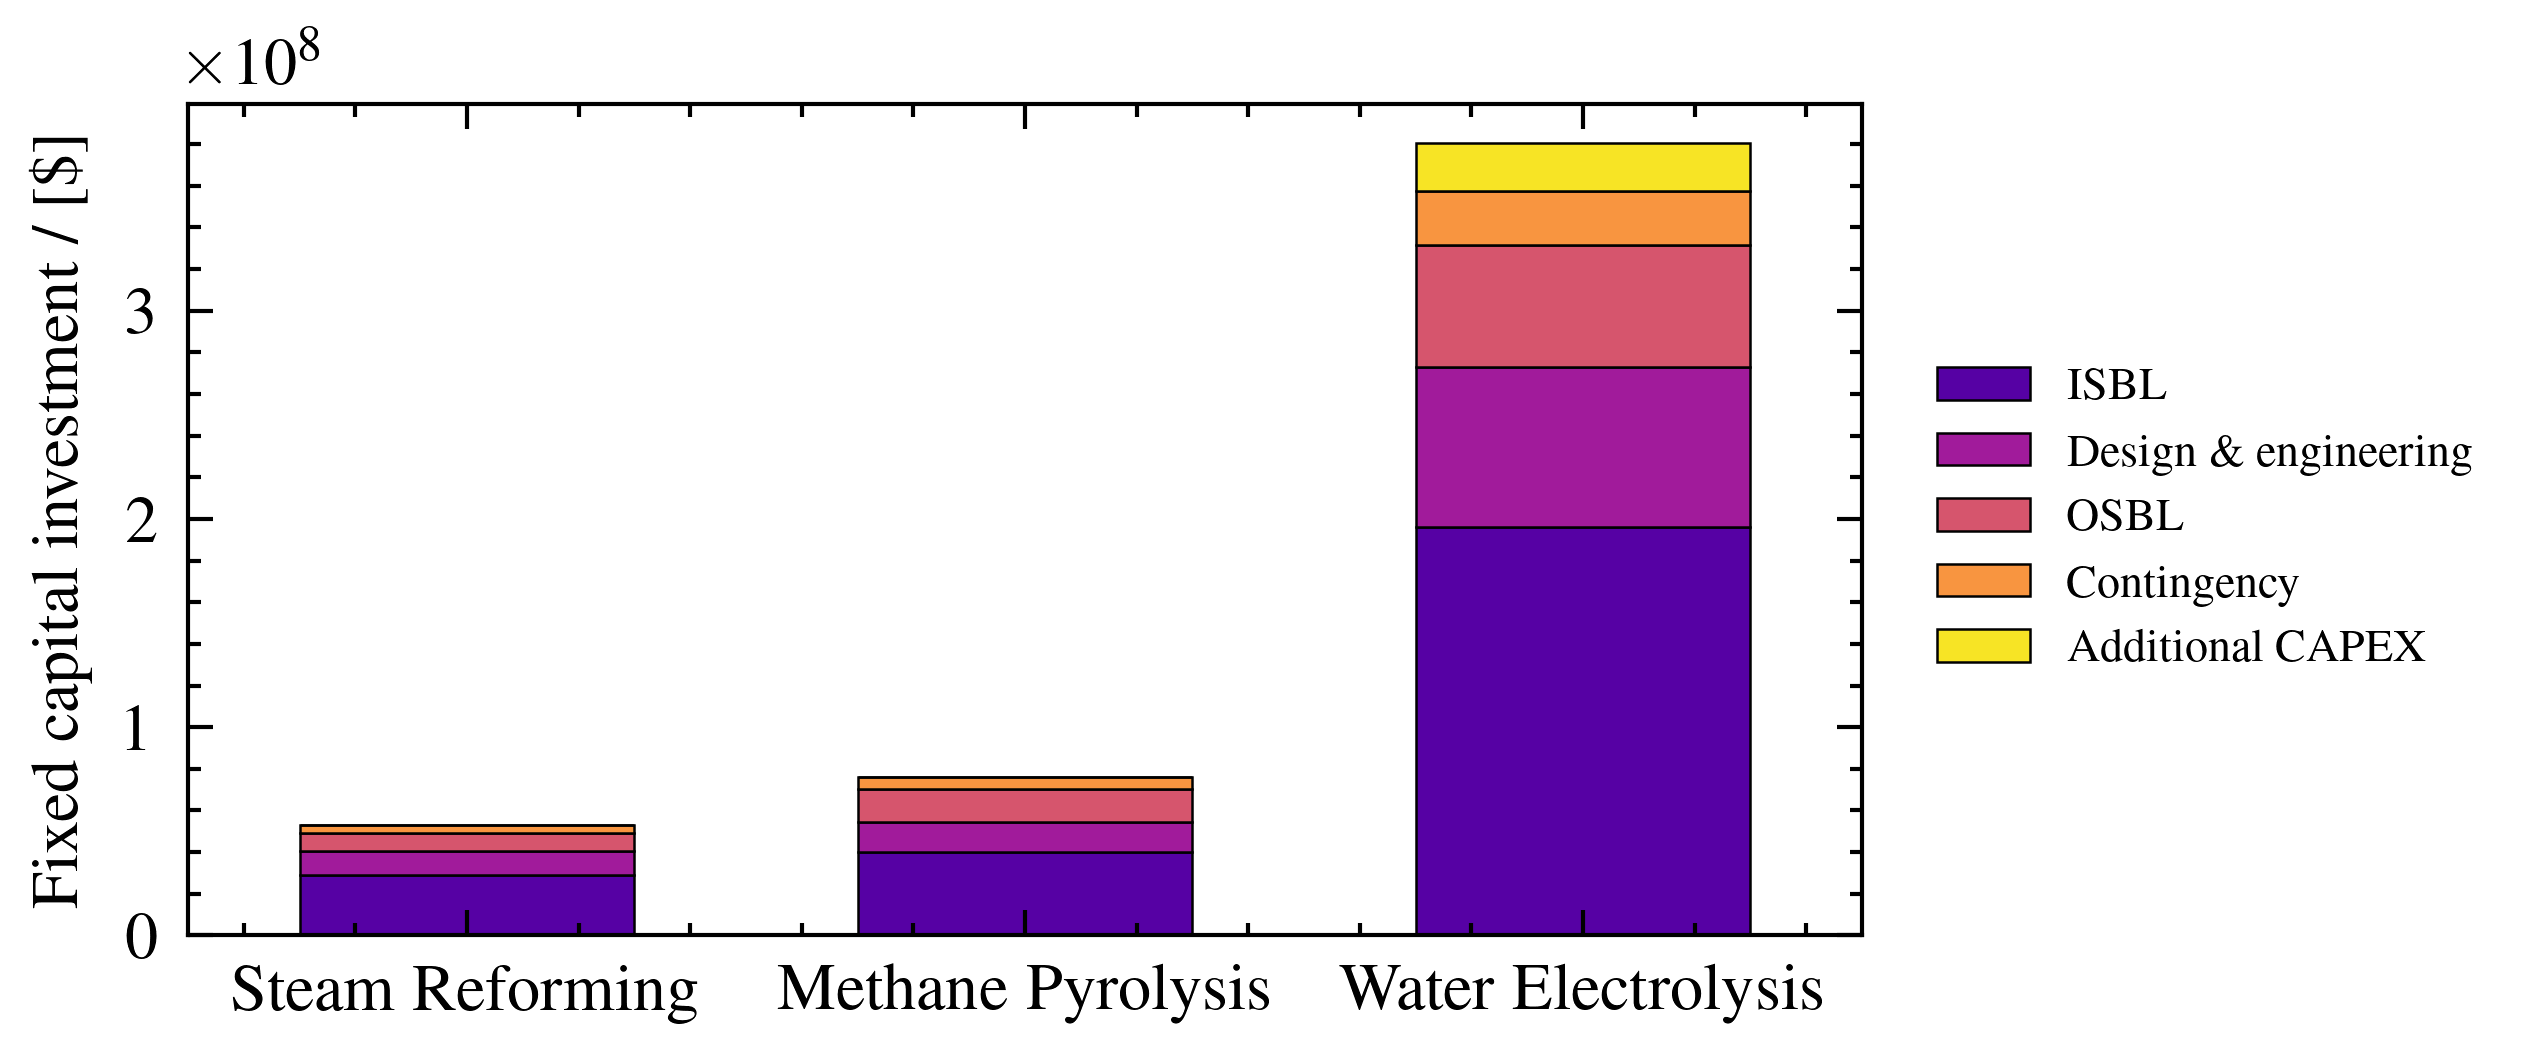

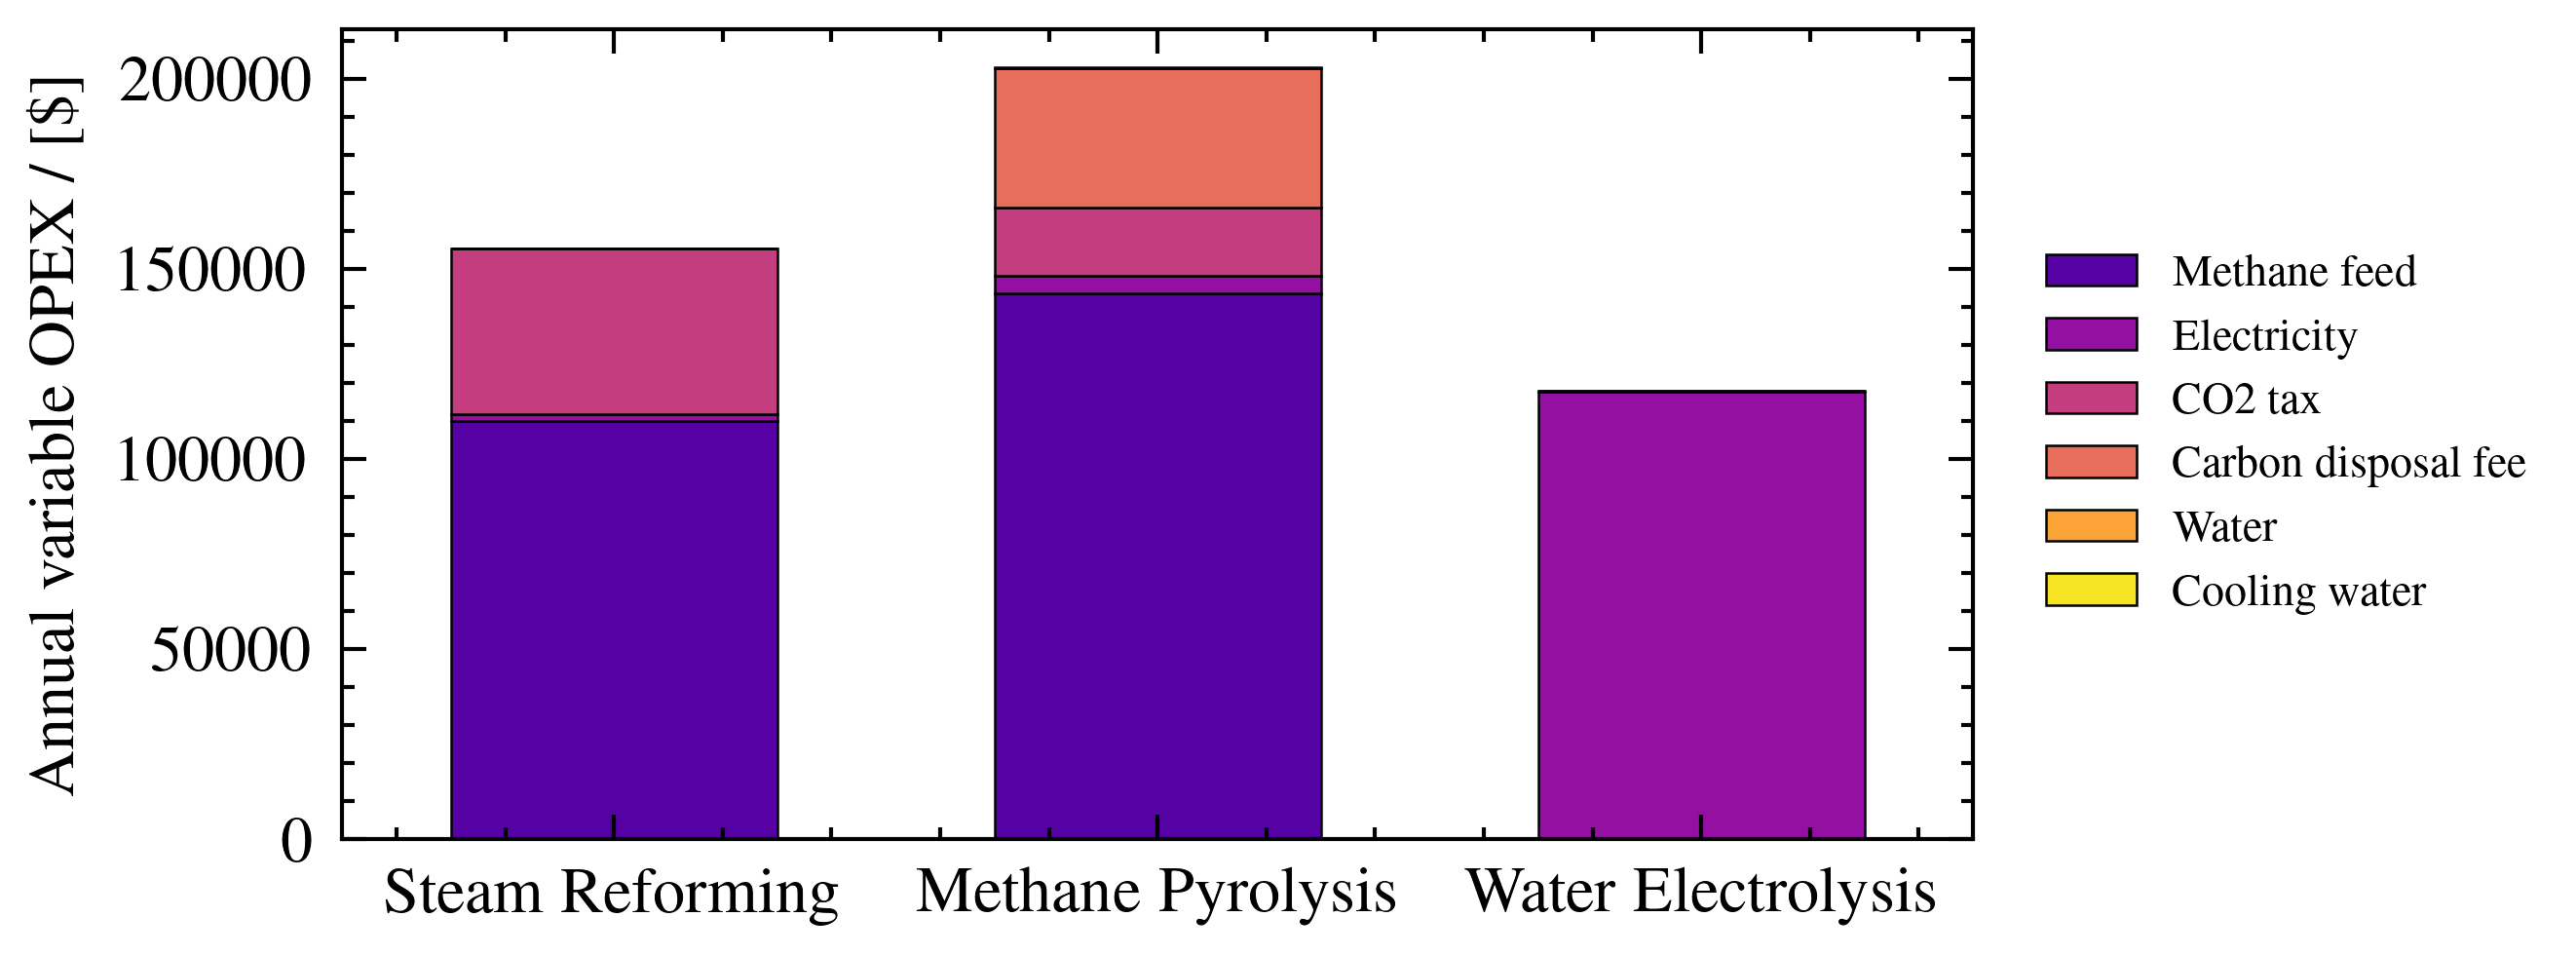

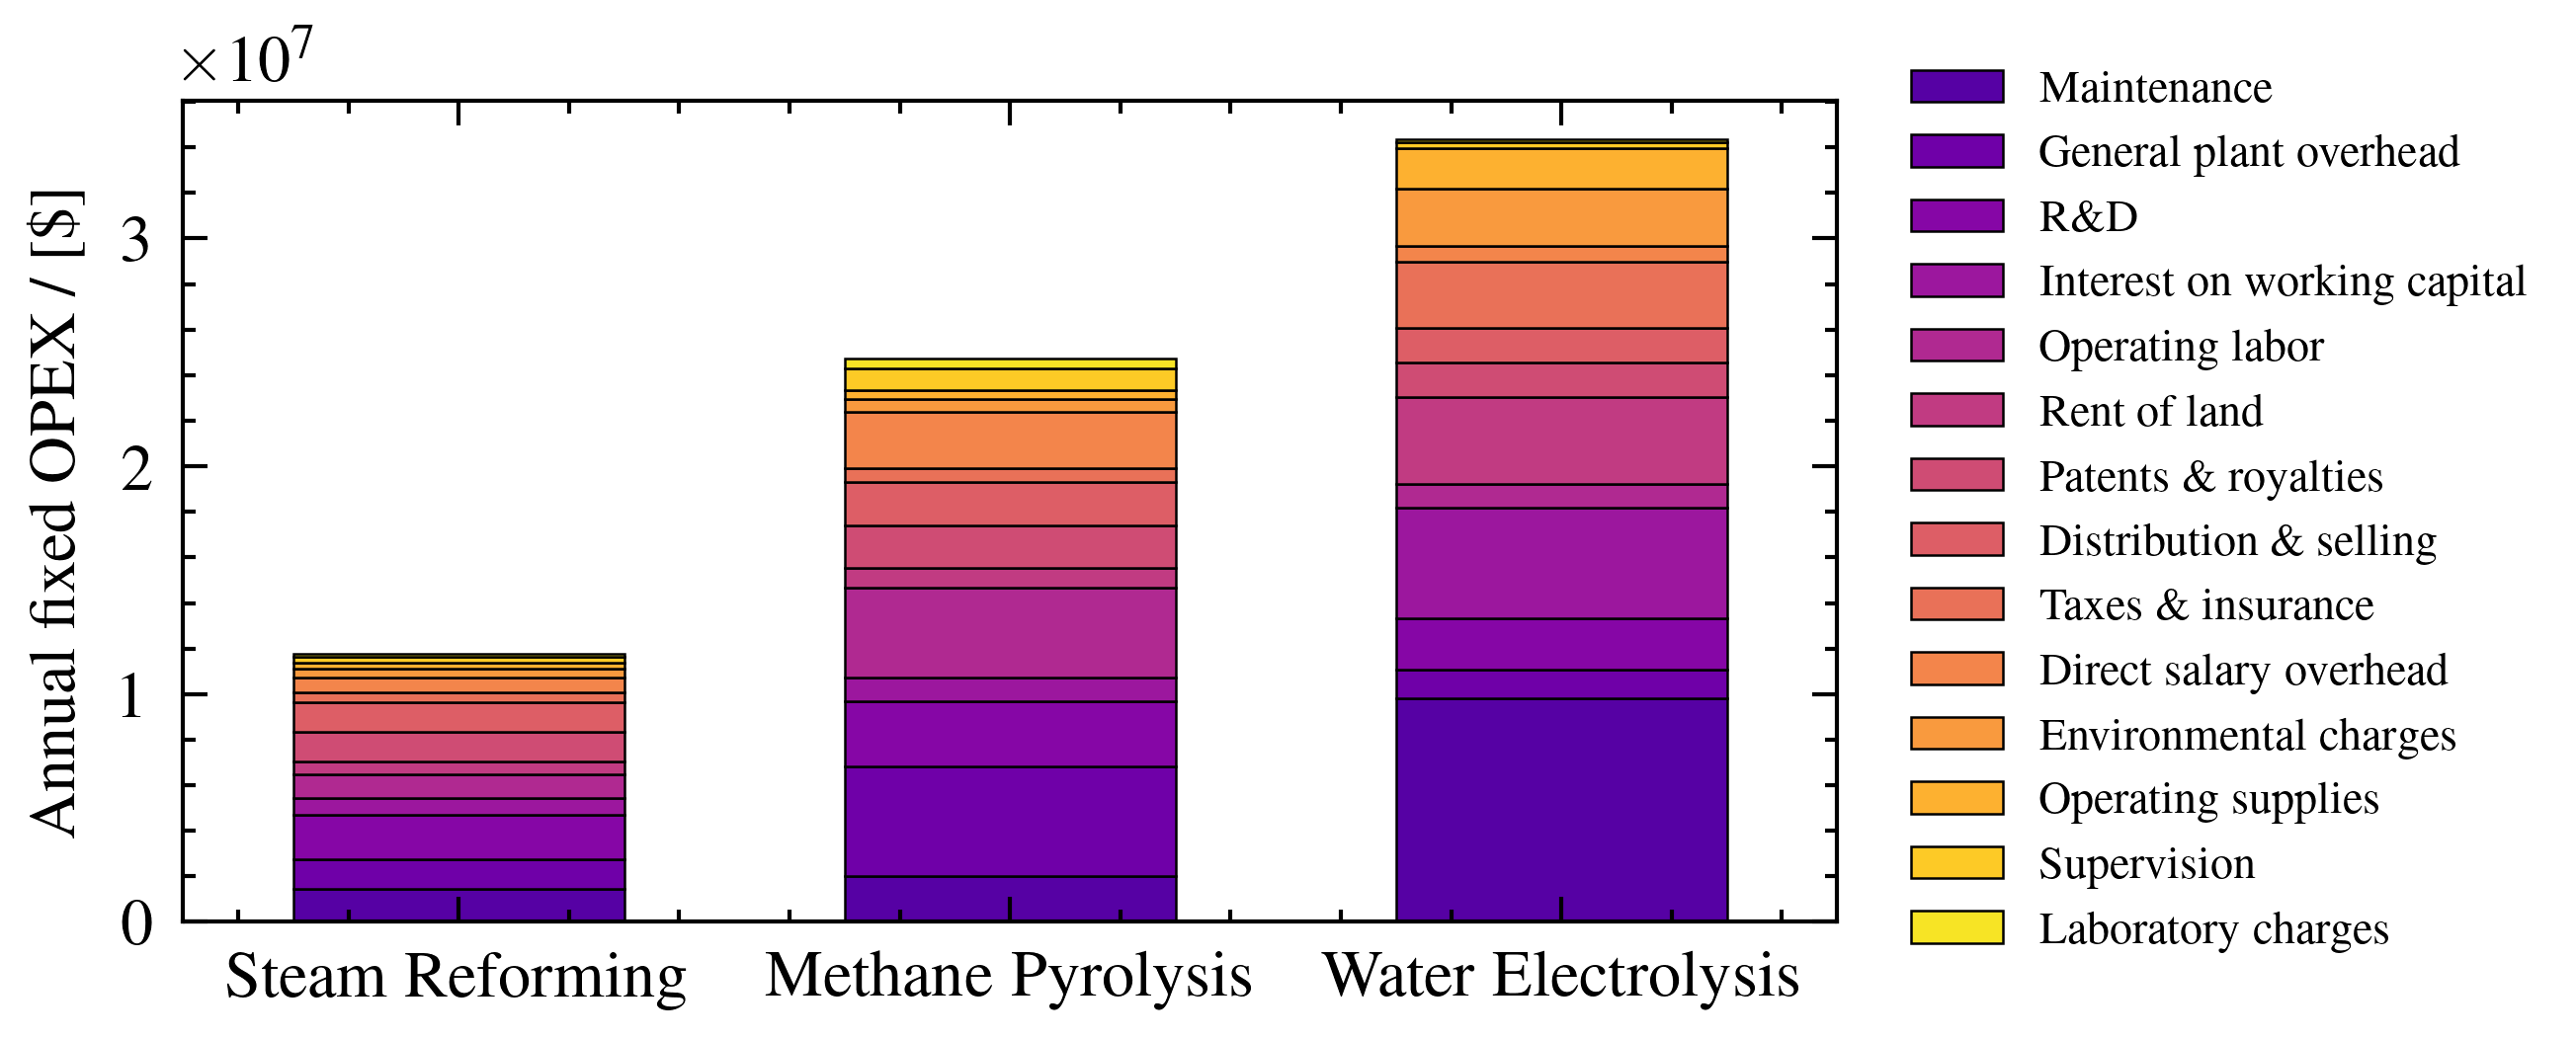

In [19]:
plot_fixed_capital_bar([smr_plant, mp_plant, we_plant], additional_capex=True)
plot_variable_opex_bar([smr_plant, mp_plant, we_plant])
plot_fixed_opex_bar([smr_plant, mp_plant, we_plant])

<p style="text-align: justify;"> The breakdown plots highlight distinct cost structures across technologies. WE is dominated by high CAPEX, while SMR and MP require substantially lower capital investment. In terms of OPEX, SMR and MP are primarily influenced by feedstock and carbon-related costs, whereas electricity dominates operating costs for WE. </p>

<p style="text-align: justify;"> Next, we generated <b>LCOH sensitivity line plots</b> comparing SMR, MP, and WE plants. We performed sensitivity analyses on the CO₂ tax to compare how carbon-pricing policies affect each technology, on the methane feed price to evaluate the impact of fuel cost fluctuations, on the carbon by-product sales price to assess potential revenue offsets, and on the electricity price to compare cost sensitivity for electricity-intensive pathways. </p>

1. Sensitivity of LCOH to CO₂ tax:

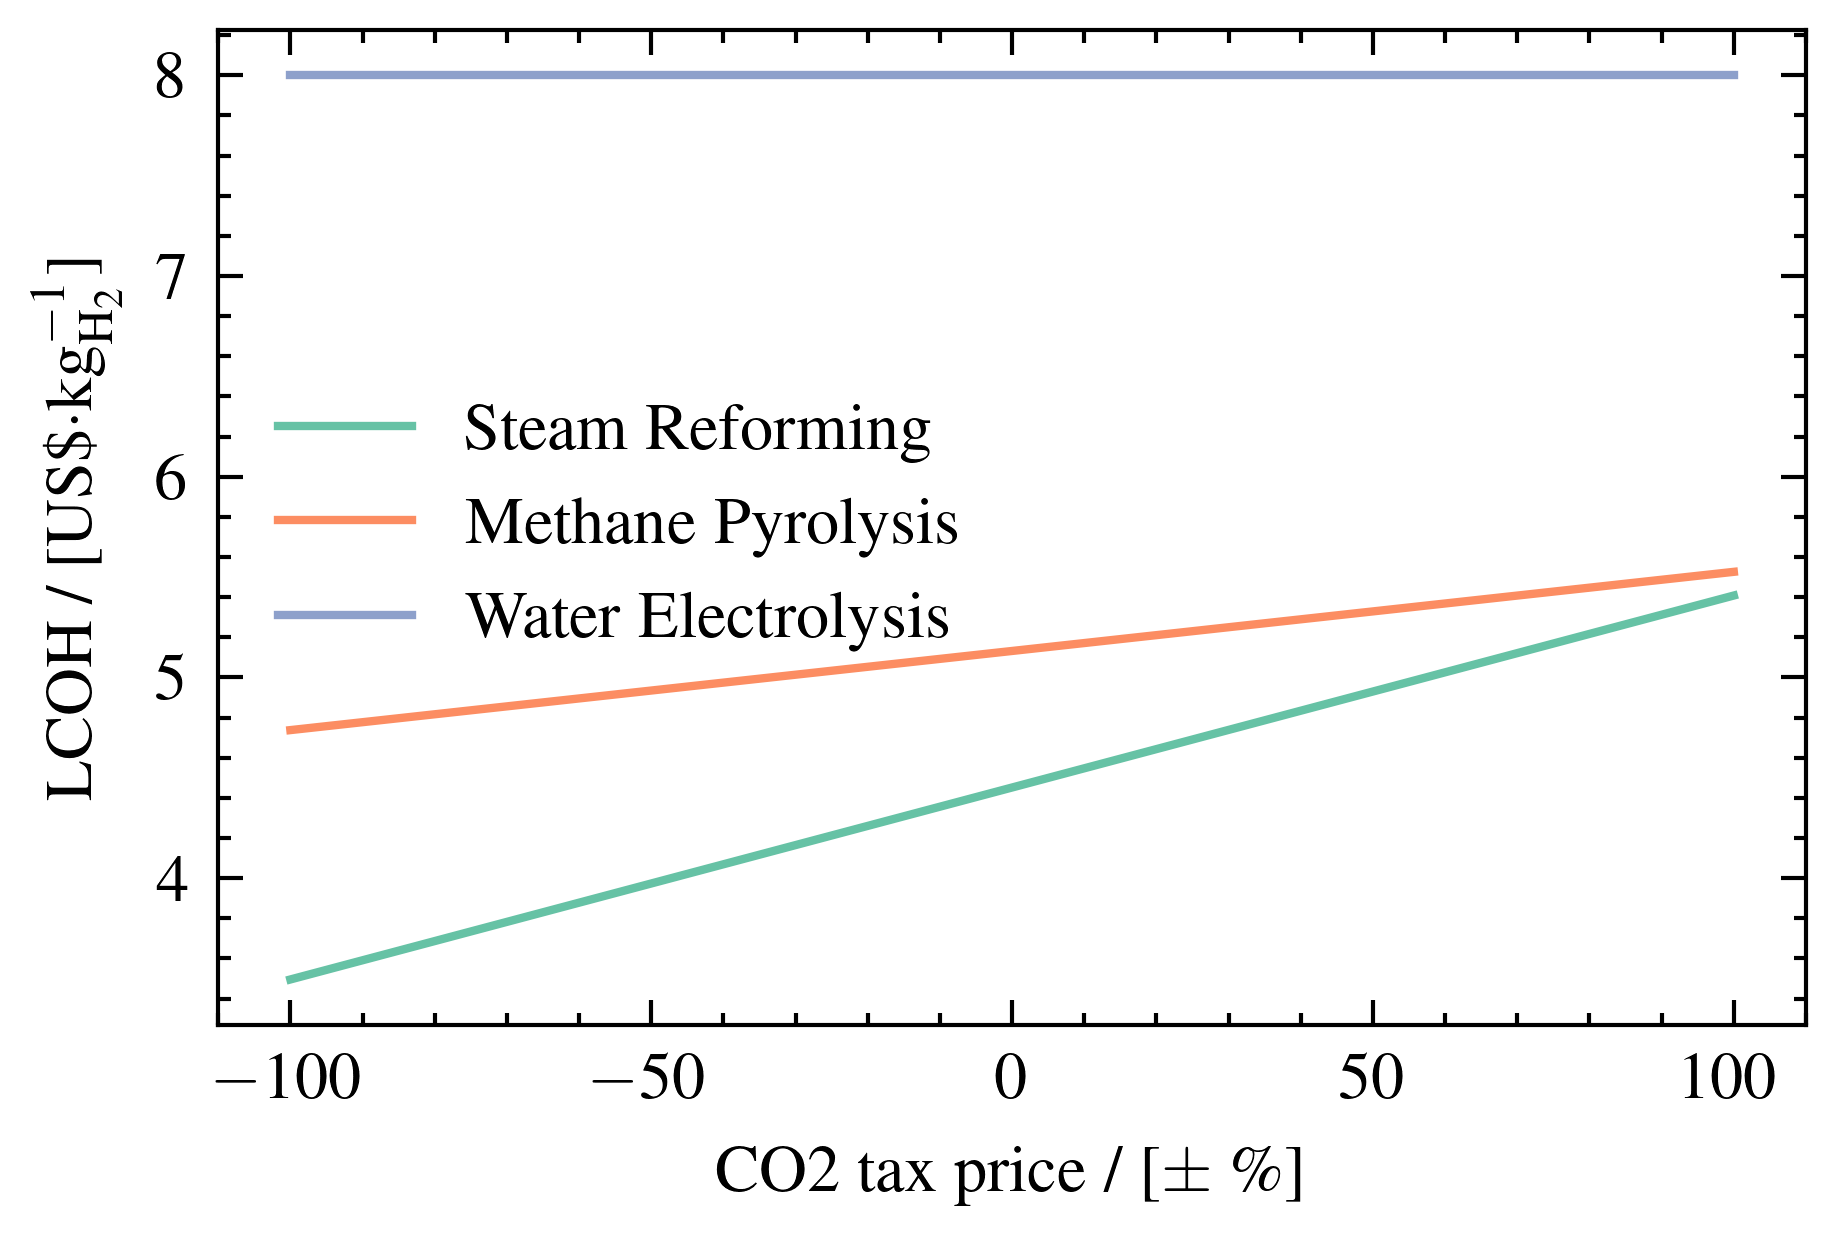

In [20]:
sensitivity_plot([smr_plant, mp_plant, we_plant], 'CO2_tax', 1, 
                 label=r'LCOH / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

Above plot shows the sensitivity of the LCOH for SMR, MP, and WE as the CO₂ tax varies from –100% to +100%. The results shows that increasing CO₂ tax significantly raises the LCOH for SMR, moderately affects MP, and has no influence on WE due to its zero direct carbon emissions.

2. Sensitivity of LCOH to methane feed price:

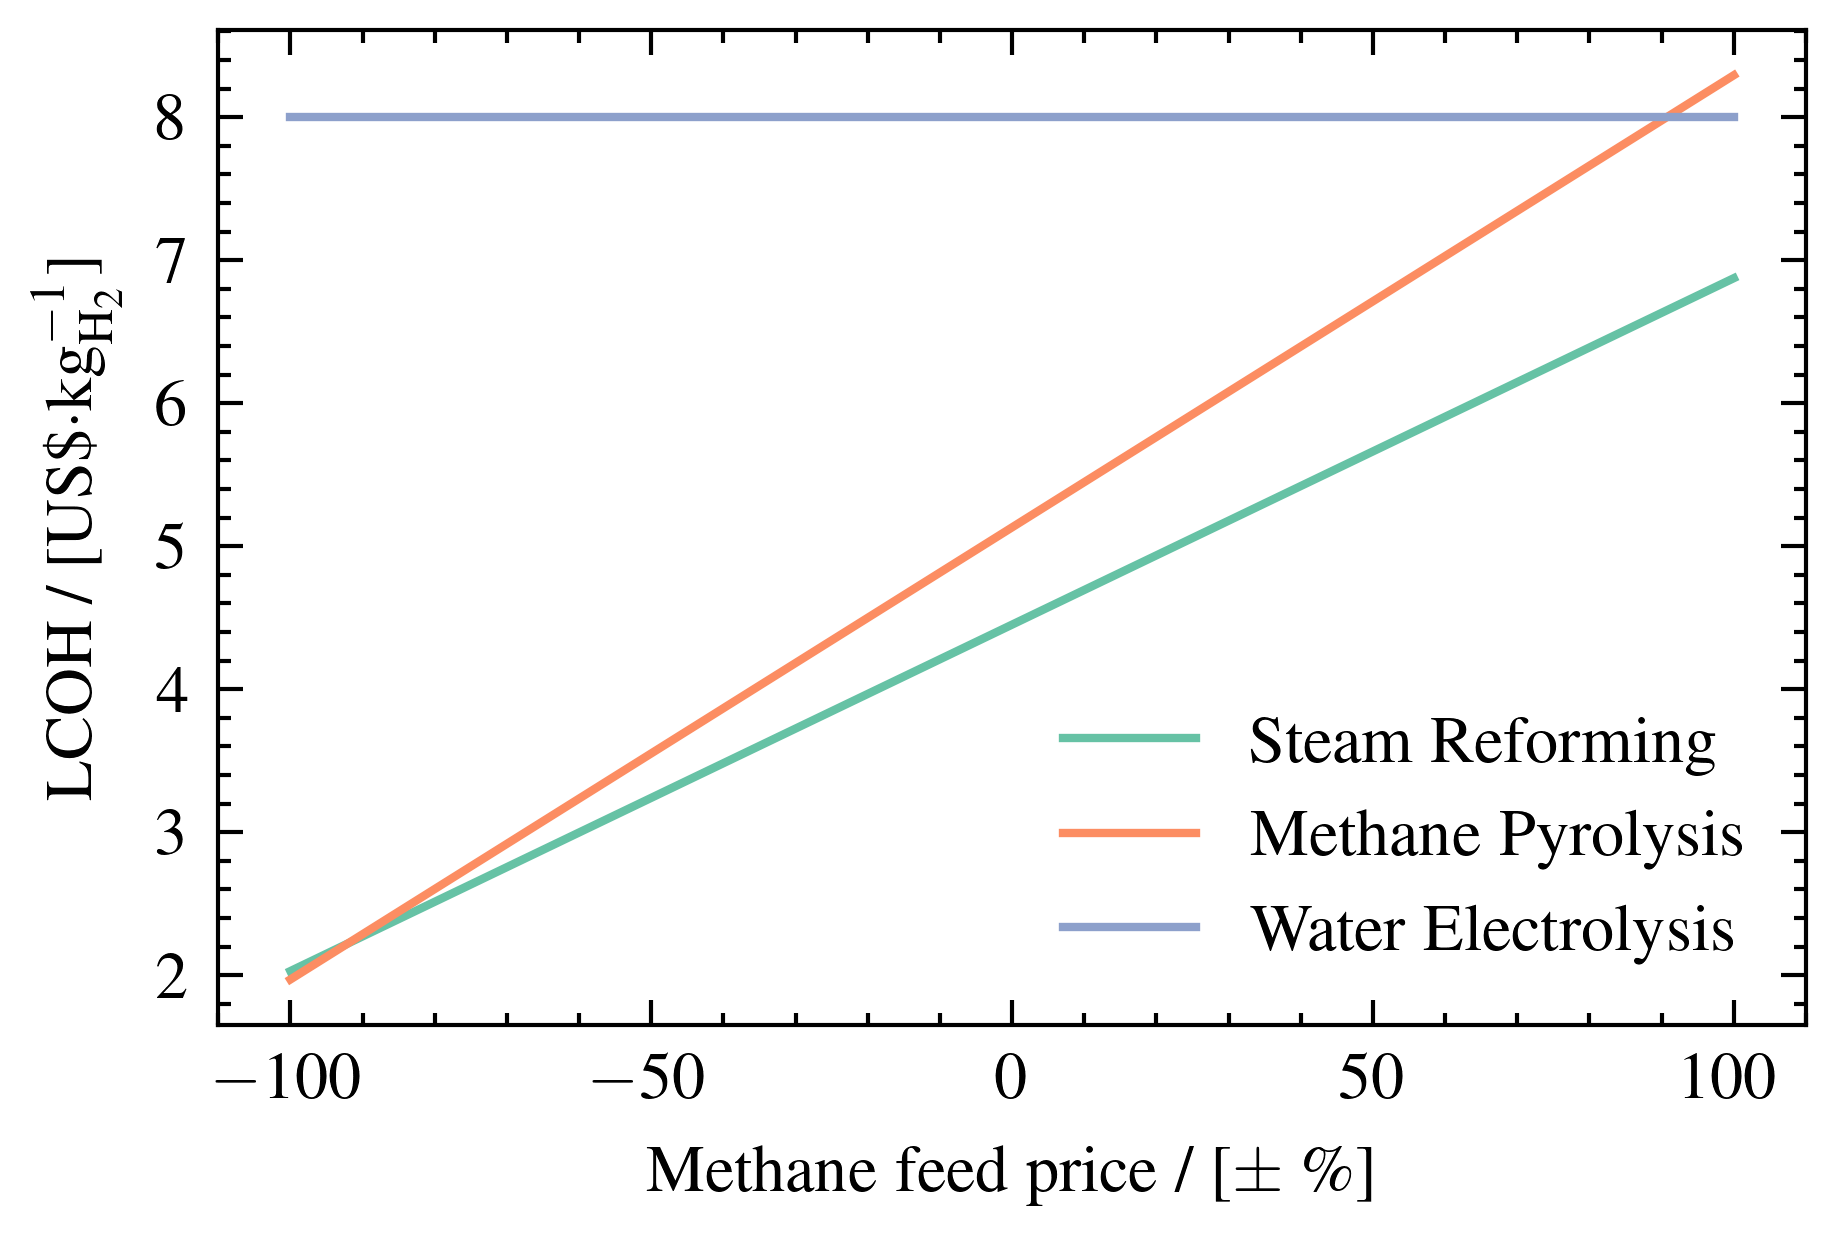

In [21]:
sensitivity_plot([smr_plant, mp_plant, we_plant], 'methane_feed', 1, label=r'LCOH / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

Here we can see that both SMR and MP exhibit substantial increases in LCOH with rising methane prices, whereas WE remains insensitive since methane is not a process input.

3. Sensitivity of LCOH to carbon byproduct sales:

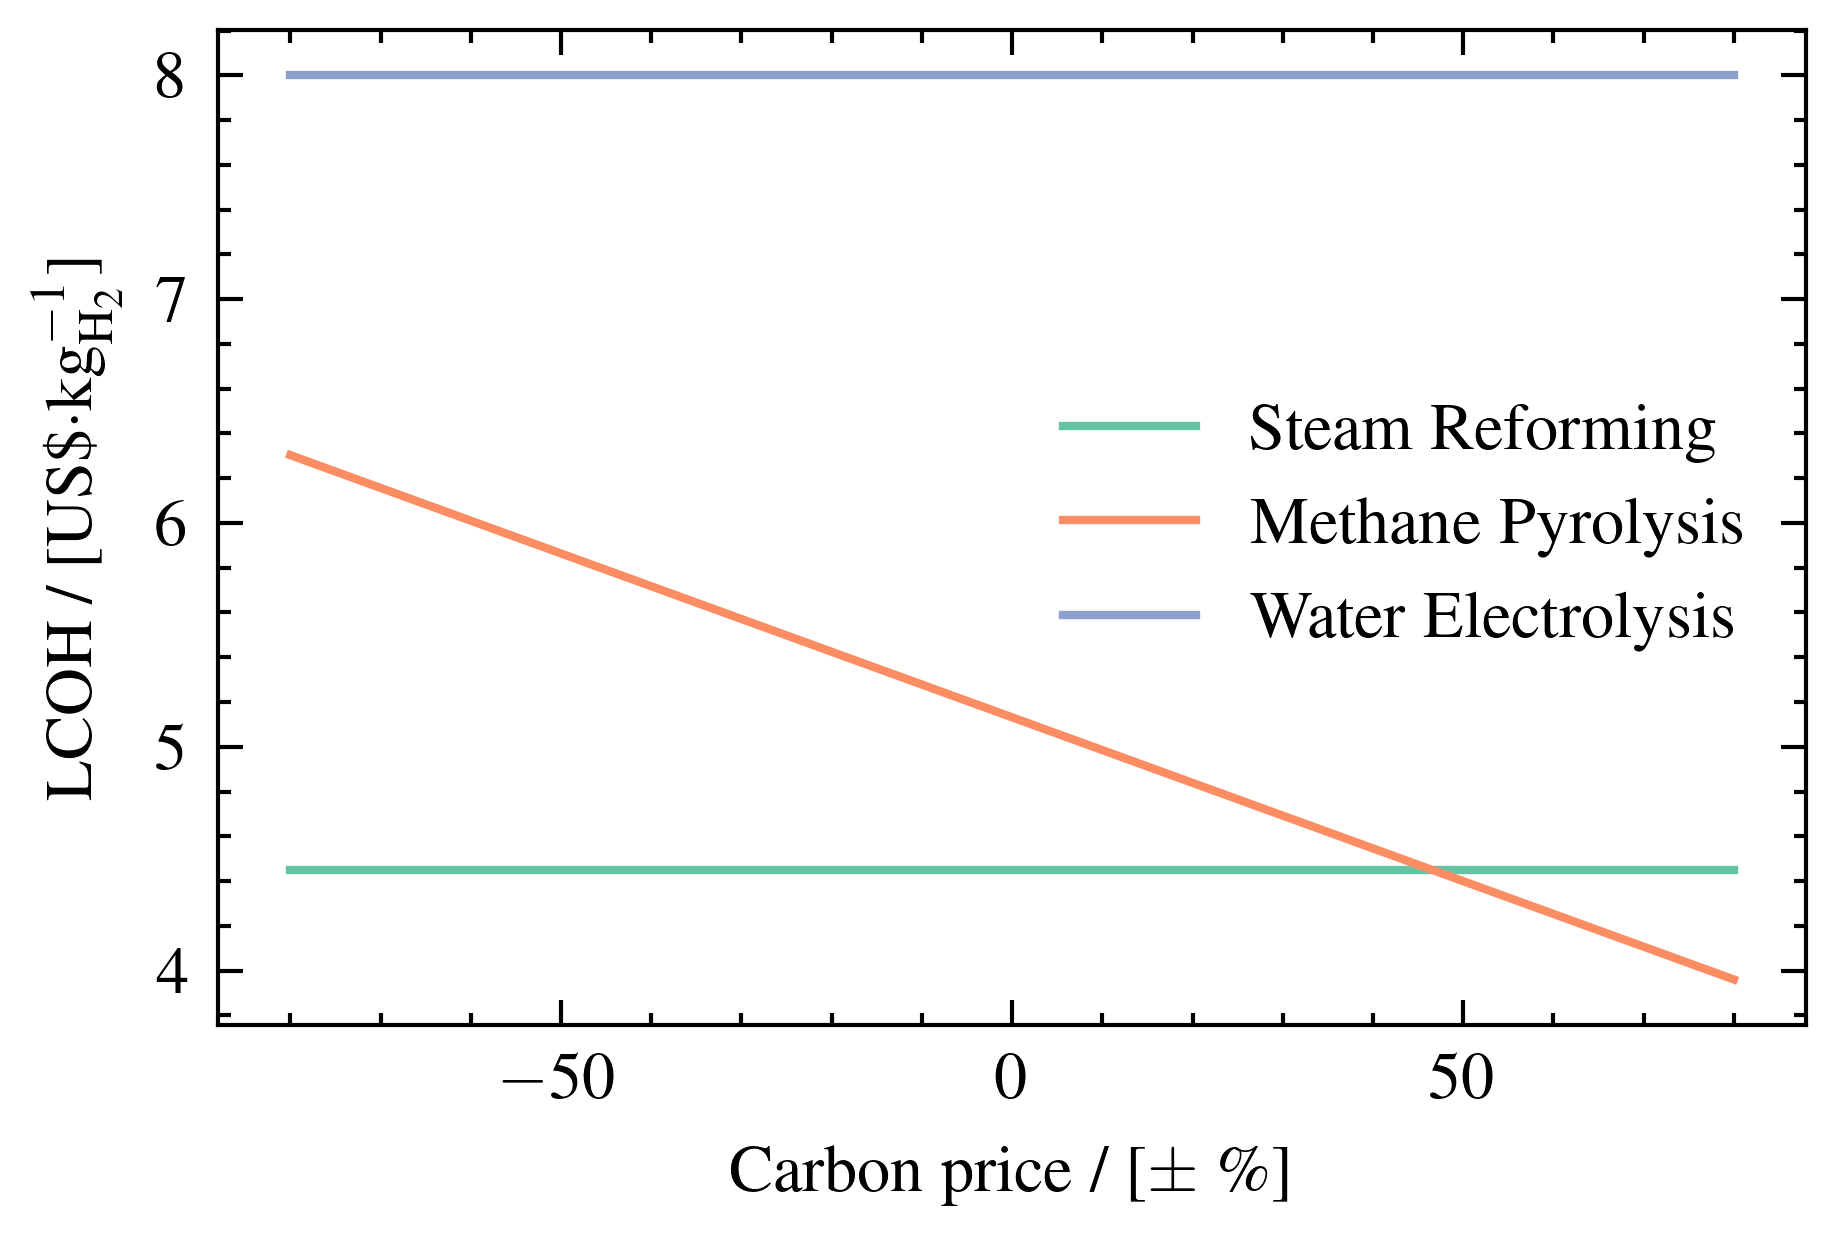

In [22]:
sensitivity_plot([smr_plant, mp_plant, we_plant], 'carbon', 0.8, label=r'LCOH / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

As the carbon by-product sale price increases, the resulting revenue in methane pyrolysis can lower its hydrogen cost to below that of SMR; and even at very low carbon sale prices, the LCOH remains well below that of water electrolysis.

4. Sensitivity of LCOH to electricity price:

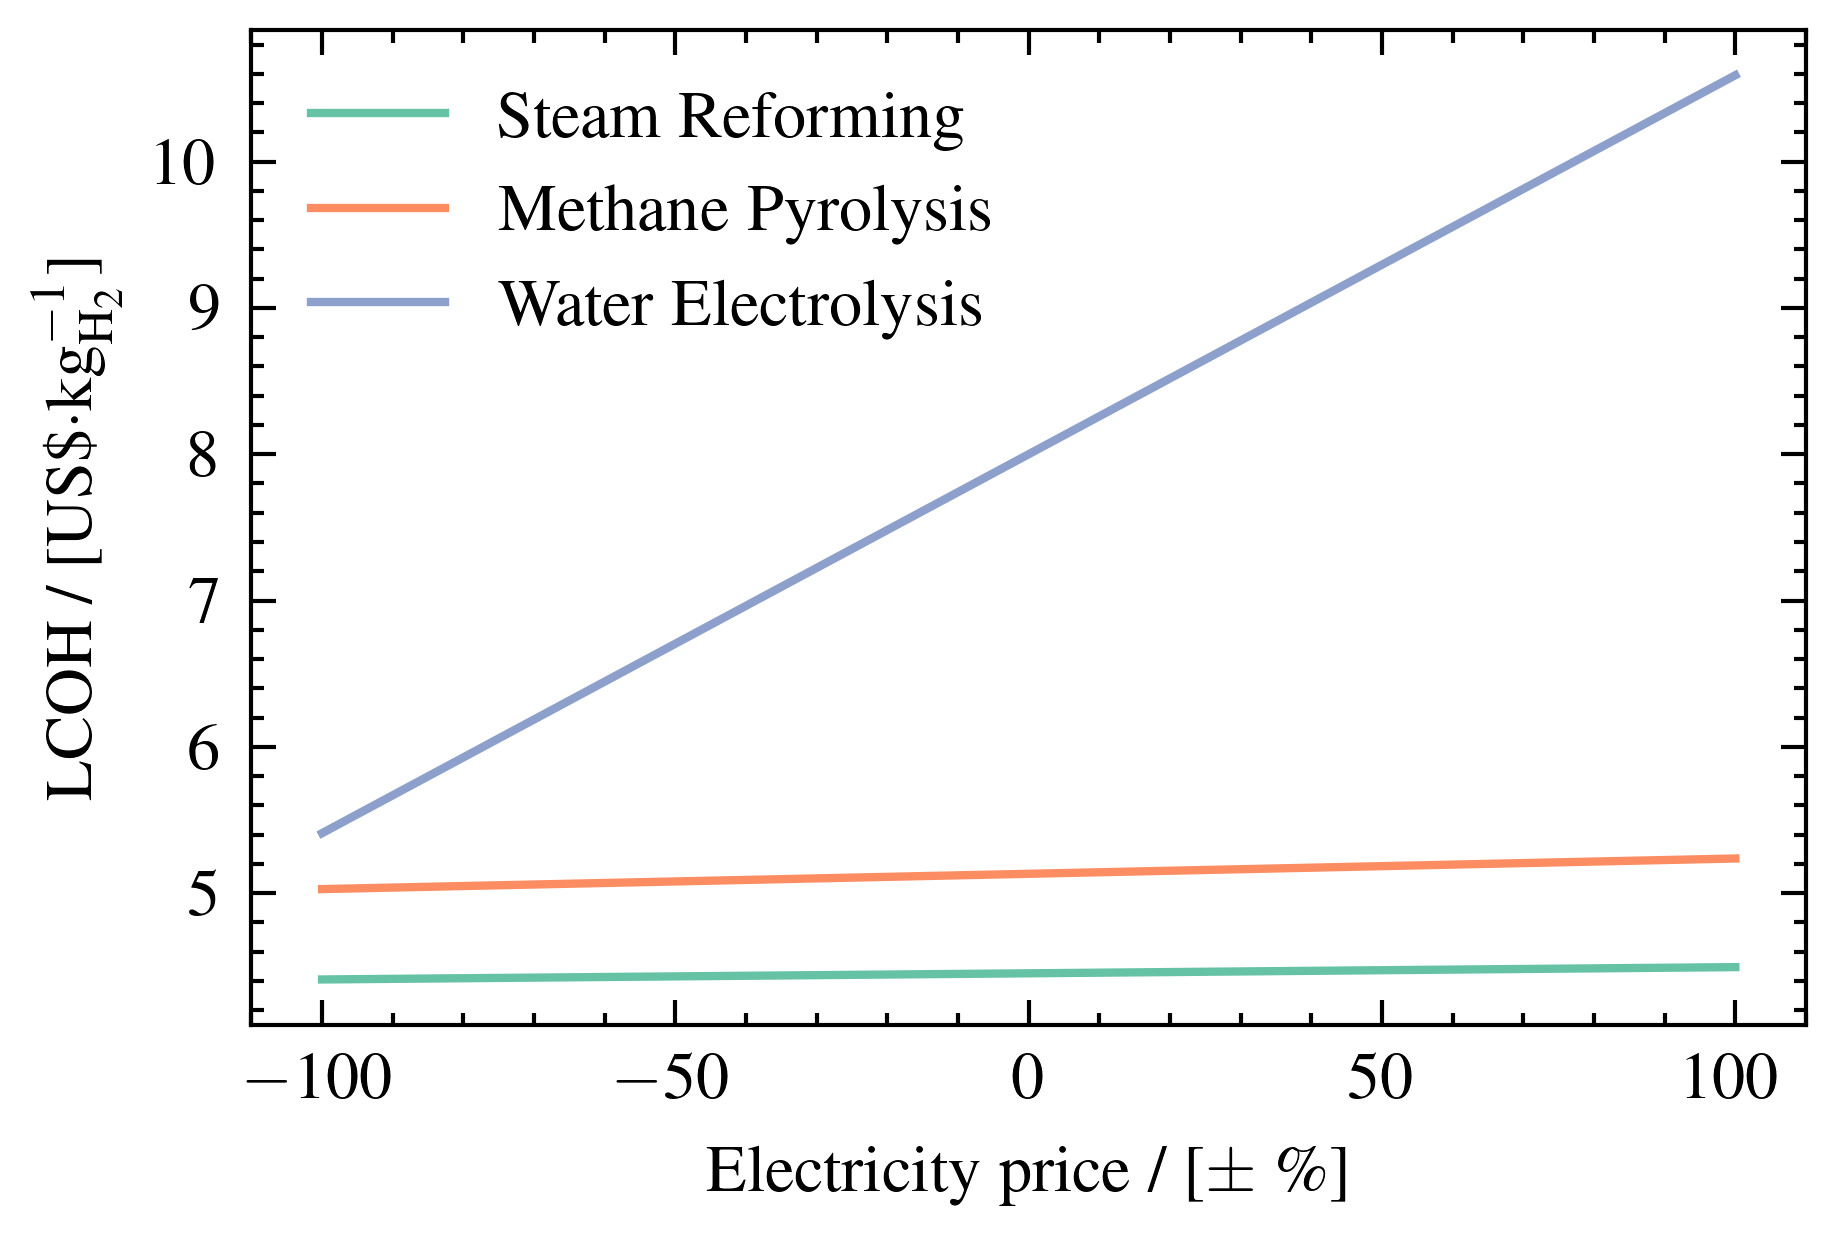

In [23]:
sensitivity_plot([smr_plant, mp_plant, we_plant], 'electricity', 1, label=r'LCOH / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

WE exhibits a strong dependence on electricity price, and the analysis shows that even under very low electricity-cost conditions, WE still produces H₂ at a higher cost than both SMR and MP.

Having examined the effect of individual parameters on the LCOH for SMR, MP, and WE, we now move to a Monte Carlo analysis to evaluate how simultaneous fluctuations in key inputs influence the overall cost distribution for each technology. Below, we present a comparison of the Monte Carlo simulation results for the three H₂ plants:

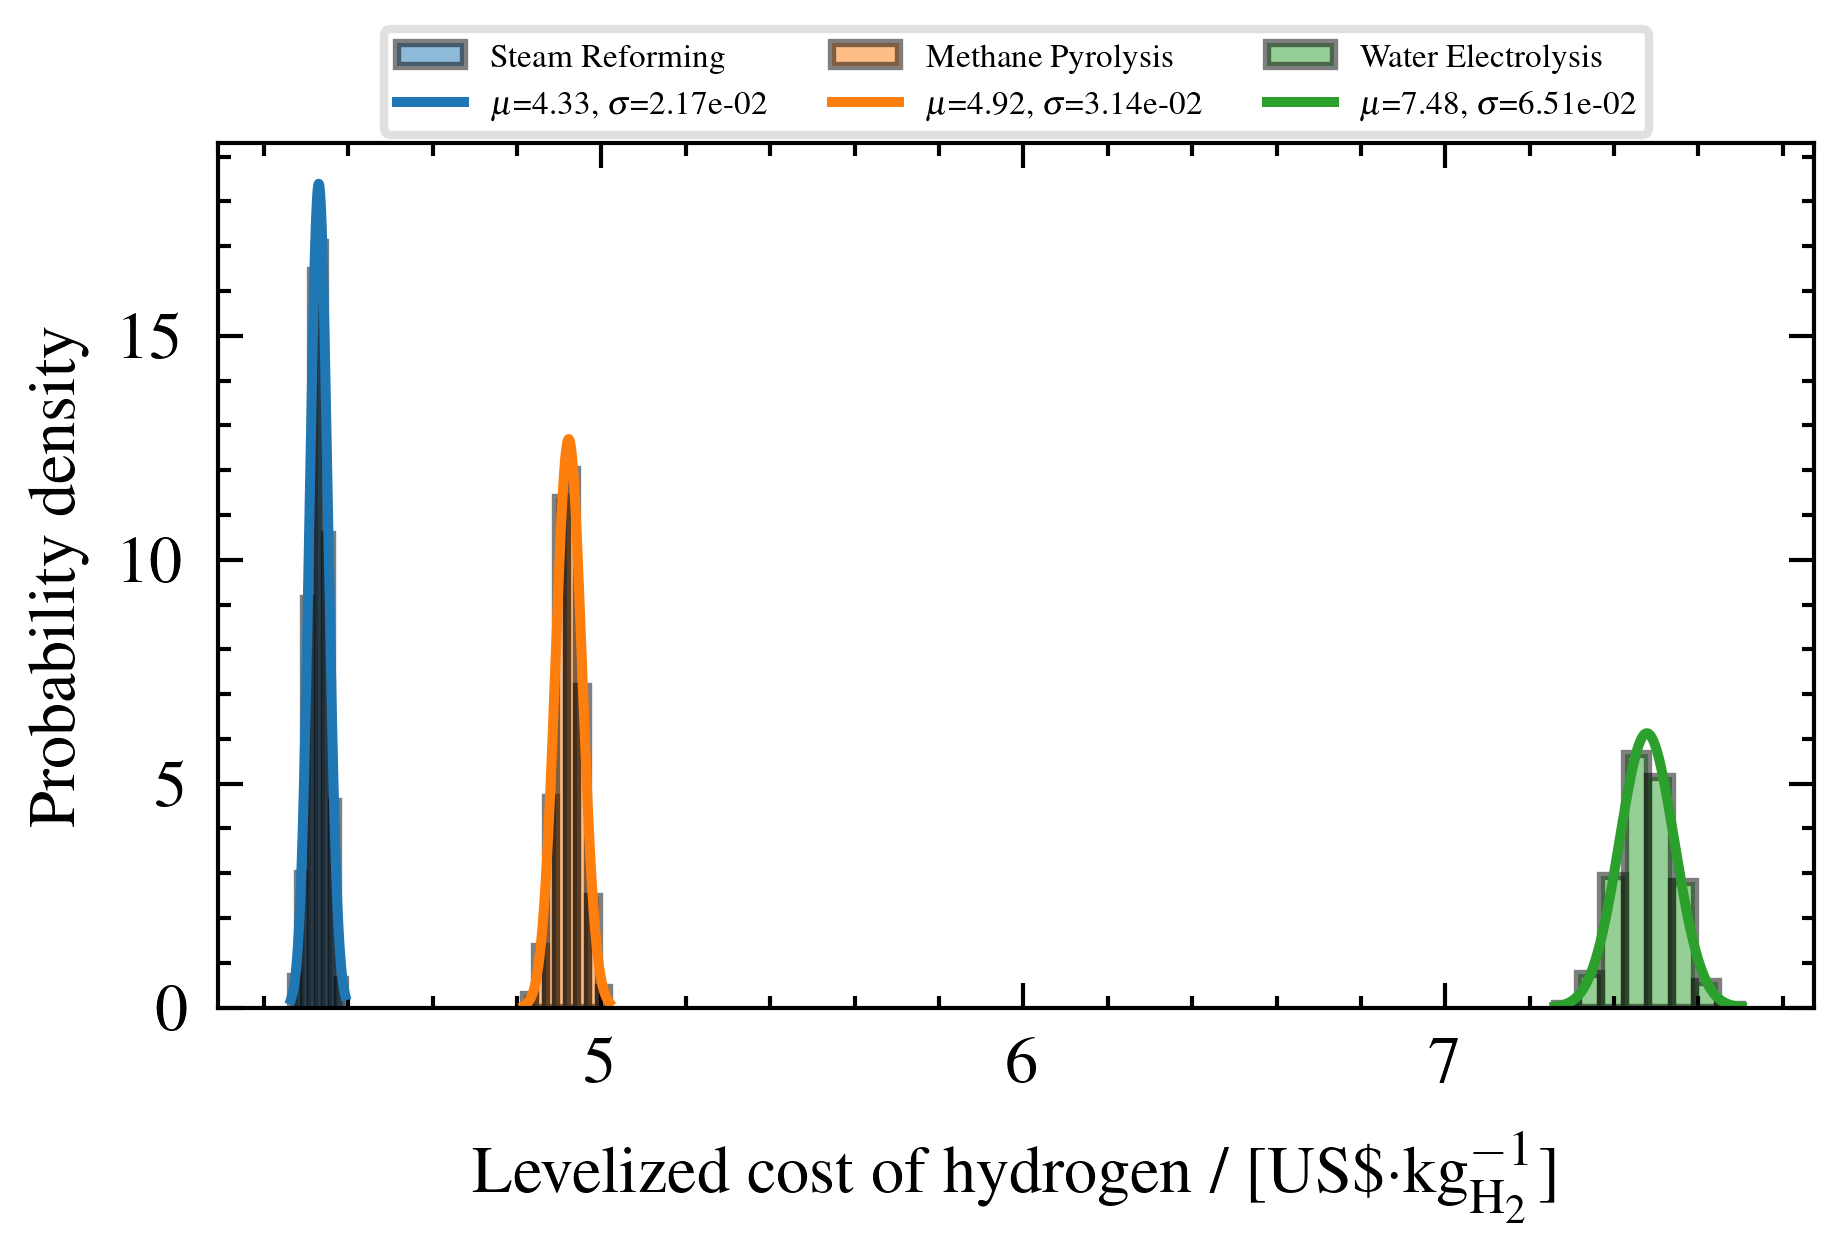

In [24]:
plot_multiple_monte_carlo([smr_plant, mp_plant, we_plant], bins=8, label=r'Levelized cost of hydrogen / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')

<p style="text-align: justify;">
The Monte Carlo simulation results reveal distinct cost distributions for the three H₂ production pathways. SMR shows the lowest mean LCOH at approximately 4.3 USD/kg with a very narrow spread, indicating low sensitivity to combined parameter uncertainties. MP exhibits a slightly higher mean LCOH of about 4.74 USD/kg and a moderately wider distribution, reflecting greater variability driven by factors such as methane price and carbon by-product revenue. WE, meanwhile, displays the highest mean LCOH at around 7.29 USD;/kg with the widest distribution, highlighting its strong dependence on uncertain inputs—specifically electricity price. Overall, the probabilistic analysis reinforces the relative economic ranking observed in the deterministic results: SMR remains the lowest-cost pathway, followed by MP, while WE consistently yields the highest H₂ production cost even under favorable conditions.
</p>

<p style="text-align: justify;"> This demonstration highlights how OpenPyTEA streamlines and strengthens TEA by providing a transparent and fully reproducible framework. Through consistent plant cost estimations, automated sensitivity studies, and integrated Monte Carlo analysis, OpenPyTEA enables users to efficiently explore uncertainties, compare alternative technologies, and generate clear insights. These capabilities lower the barrier for conducting robust TEAs and for accelerating informed decision-making in H₂ production and beyond.</p>

## References

[1] Acevedo, Y. M.; Prosser, J. H.; Huya-Kouadio, J. M.; McNamara, K. R.; James, B. D. Hydrogen Production Cost with Alkaline Electrolysis; DOE-SA--09629-1; Strategic Analysis, Inc., Arlington VA (United States), 2023. https://doi.org/10.2172/2203367.

[2] Boyano, A.; Blanco-Marigorta, A. M.; Morosuk, T.; Tsatsaronis, G. Exergoenvironmental Analysis of a Steam Methane Reforming Process for Hydrogen Production. Energy 2011, 36 (4), 2202–2214. https://doi.org/10.1016/j.energy.2010.05.020.

[3] Xu, J.; Froment, G. F. Methane Steam Reforming, Methanation and Water-Gas Shift: I. Intrinsic Kinetics. AIChE Journal 1989, 35 (1), 88–96. https://doi.org/10.1002/aic.690350109.

[4] Choi, Y.; Stenger, H. G. Water Gas Shift Reaction Kinetics and Reactor Modeling for Fuel Cell Grade Hydrogen. Journal of Power Sources 2003, 124 (2), 432–439. https://doi.org/10.1016/S0378-7753(03)00614-1.

[5] Keipi, T.; Tolvanen, K. E. S.; Tolvanen, H.; Konttinen, J. Thermo-Catalytic Decomposition of Methane: The Effect of Reaction Parameters on Process Design and the Utilization Possibilities of the Produced Carbon. Energy Conversion and Management 2016, 126, 923–934. https://doi.org/10.1016/j.enconman.2016.08.060.

[6] Keipi, T.; Tolvanen, H.; Konttinen, J. Economic Analysis of Hydrogen Production by Methane Thermal Decomposition: Comparison to Competing Technologies. Energy Conversion and Management 2018, 159, 264–273. https://doi.org/10.1016/j.enconman.2017.12.063.